In [1]:
import numpy as np
import pandas as pd
import random as rnd
from numpy import linalg as la
import time
import matplotlib.pyplot as plt
import datetime
import pickle

%matplotlib inline
plt.rc('figure', figsize=(14, 7))

SEED = 666
rnd.seed(SEED)

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


### Utility functions

In [2]:
def make_random_bins(observations, bin_size):
    n_obs = len(observations)
    shuffled_obs = observations
    rnd.shuffle(shuffled_obs)
    
    bins = [shuffled_obs[k*bin_size:(k+1)*bin_size] for k in range(n_obs//bin_size-1)]
    
    if n_obs % bin_size != 0:
        bins.append(shuffled_obs[n_obs//bin_size:])
    
    return bins

def make_bins_i(n_obs, bin_size):
    bins_indexes = []
    bins_indexes.append(0)
    bins_indexes = [k * bin_size for k in range(n_obs//bin_size)]
    bins_indexes.append(n_obs)
    return(bins_indexes)

obs = [(1,4,3), (2,7,5), (4,8,2), (1,3,5), (3,6,5), (2,1,3)]
make_bins_i(6, 3)

[0, 3, 6]

### Data Integration

In [3]:
ratings = pd.read_csv('./data/u.data.csv', sep='|')
itemsdf = pd.read_csv('./data/u.item.csv', sep='|')
usersdf = pd.read_csv('./data/u.user.csv', sep='|')

# Compute UI matrix
UI = ratings.pivot(index='user.id', columns='item.id', values='rating')

# Compute list of unique users/items
items = ratings['item.id'].unique()
n_items = len(items)
users = ratings['user.id'].unique()
n_users = len(users)

itemid_to_rank = {items[k]:k for k in range(len(items))}
userid_to_rank = {users[k]:k for k in range(len(users))}

# Construct user means and items means
umeans = ratings.groupby('user.id')['rating'].mean()
umeans = umeans.values
imeans = ratings.groupby('item.id')['rating'].mean()
imeans = imeans.values

# Construct date and day columns
ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
ratings['date'].describe()
months = dict({'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
              'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'})

min_date = min(ratings['date'])
ratings['day'] = ratings['date'].apply(lambda x: (x - min_date).days)

# Construct release_date and days since release columns
def f(x): 
    if isinstance(x,str):
        if months.get(x[3:6]):
            return x[0:3] + months.get(x[3:6]) + x[6:]
        else:
            return(x)
    else: 
        return '01-01-1995'

for k in range(len(itemsdf)):
    itemsdf.ix[k,' release date '] = f(itemsdf.ix[k,' release date '])
itemsdf.ix[itemsdf[' release date '] == '4-Feb-1971',' release date '] = '04-02-1995'
itemsdf['release_date'] = itemsdf[' release date '].apply(lambda x: datetime.datetime.strptime(x, '%d-%m-%Y'))

# Construct av_vote_day column and date_to_av_voteday
av_day = dict(ratings.groupby('user.id')['day'].mean())
ratings['av_vote_day'] = ratings['user.id'].apply(lambda x: int(av_day[x]))
ratings['date_to_av_voteday'] = np.sign(ratings['day'] - ratings['av_vote_day']) * (abs(ratings['day'] - ratings['av_vote_day'])**0.5)

# Construct datebin column
quantiles = ratings['date'].quantile([0.33, 0.66, 1])

def datebinarizer(date):
    if date <= quantiles[0.33]:
        return 1
    elif date <= quantiles[0.66]:
        return 2
    else: return 3
ratings['datebin'] = ratings['date'].apply(datebinarizer)

# Construct observations arrays
observations = [(ratings.ix[k, 'user.id'],
                 ratings.ix[k, 'item.id'],
                 float(ratings.ix[k, 'rating']),
                ratings.ix[k, 'datebin'], 
                ratings.ix[k, 'date_to_av_voteday']) for k in range(len(ratings))]
rnd.shuffle(observations)

### SVD0 : SVD without bias terms

In [4]:
p_init0  = np.random.rand(n_users, 50) * 2 - 1.0
q_init0  = np.random.rand(n_items, 50) * 2 - 1.0

In [5]:
def sgd_svd0(lrate, obs_ui, obs_rates, q_init, p_init, reg, batch_indexes):
    
    n_obs = len(obs_ui)
    n_batch = len(batch_indexes) - 1
    obj_evals = []
    te_rmse_evals = []
    
    p = p_init
    q = q_init
    
    obj_rmse, obj_reg = fobj_svd0(obs_ui, obs_rates, reg, p, q)
    epoch_obj = obj_rmse + obj_reg
    last_epoch_obj = 0.0
    n_epoch = 0
    n_iter = 0
    n_decay = 0
    n = 0
    
    while (n_epoch < 50) & (n_decay < 10):
        
        # Construct batch of observations
        batch_ui = obs_ui[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        batch_rates = obs_rates[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        
        # Update parameters
        (grad_p, grad_q) = grad_svd0_pq(batch_ui, batch_rates, reg, p, q)
        p = p - lrate * grad_p
        q = q - lrate * grad_q
        n_iter += 1
        
        if n_iter % n_batch == 0:
            
            n_epoch += 1
            n += 1
            #print("Epoch : " + str(n_epoch))
            
            # Compute train objective (rmse)
            obj_rmse, obj_reg = fobj_svd0(obs_ui, obs_rates, reg, p, q)
            last_epoch_obj = epoch_obj
            epoch_obj = obj_rmse + obj_reg
            
            # Compute last gradient norm
            norm = np.sqrt((sum(sum(grad_p*grad_p)))) + np.sqrt((sum(sum(grad_q*grad_q))))
            
            # Break if last rate decay improvement was too small 
            if n == 1:
                if abs(last_epoch_obj - epoch_obj) < 0.001 * last_epoch_obj:
                    break
                    
            #print("Rmse : " + str(obj_rmse/n_obs))
            #print("Obj function : " + str(obj_rmse + obj_reg))
            #print("Gradient norm " + str(norm))
            
            # Learning rate decay
            if (abs(last_epoch_obj - epoch_obj) < 0.0005 * last_epoch_obj) & (n > 2):
                #print("Rate decay")
                n = 0
                n_decay += 1
                lrate = lrate/2
                
            #if n_epoch % 6 == 0:
                #lrate = lrate/2
            
    return p, q

In [6]:
def fobj_svd0(obs_ui, obs_rates, reg, p, q):
    
    n_obs = len(obs_ui)
    
    obj_rmse = 0.0
    for k in range(n_obs):
        error = obs_rates[k] - np.inner(p[obs_ui[k,0]-1,:], q[obs_ui[k,1]-1,:])
        obj_rmse += error * error
    
    obj_reg = reg * (sum(la.norm(p, axis=1)) + sum(la.norm(q, axis=1)))
    
    return obj_rmse, obj_reg

def grad_svd0_pq(batch_ui, batch_rates, reg, p, q):
    
    n_obs = len(batch_ui)
    grad_p = np.zeros(p.shape)
    grad_q = np.zeros(q.shape)

    for k in range(len(batch_ui)):
        
        user = batch_ui[k,0]
        item = batch_ui[k,1]

        pred_vote = np.inner(p[user-1,:], q[item-1,:])
            
        error = batch_rates[k] - pred_vote    
        grad_p[user-1,:] += - error * q[item-1,:] + reg * p[user-1,:]
        grad_q[item-1,:] += - error * p[user-1,:] + reg * q[item-1,:]
    
    return grad_p, grad_q

def predict_svd0(obs_ui, obs_rates, p, q):
    
    n_obs = len(obs_ui)
    pred_votes = []
    
    for k in range(n_obs):
        pred_vote = np.inner(p[obs_ui[k,0]-1,:], q[obs_ui[k,1]-1,:])
        pred_vote = 5 if pred_vote > 5 else pred_vote
        pred_vote = 1 if pred_vote < 1 else pred_vote
        pred_votes.append(pred_vote)
    
    return np.array(pred_votes)

In [7]:
obs_ui = [[obs[0], obs[1]] for obs in observations]
obs_ui = np.array(obs_ui, dtype=np.int)
obs_rates = np.array([obs[2] for obs in observations], dtype=np.double)

In [42]:
# Single execution test
ndim = 17
batch_indexes = make_bins_i(len(observations), 200)
p_init  = np.random.rand(n_users, ndim) * 2 - 1.0
q_init  = np.random.rand(n_items, ndim) * 2 - 1.0
lrate = 0.1
reg = 0.1

sgd_svd0(lrate, obs_ui, obs_rates, q_init, p_init, reg, batch_indexes)

NameError: name 'fobj_svd0' is not defined

In [154]:
# Cross validation Code
obs_ui = [[obs[0], obs[1]] for obs in observations]
obs_ui = np.array(obs_ui, dtype=np.int)
obs_rates = np.array([obs[2] for obs in observations], dtype=np.double)

lrate = 0.1
ndims = [1, 2, 3, 4, 5, 6, 7, 10]
reg = 0.0
n_fold = 5

B0_test_dim_errors = []
B0_train_dim_errors = []

for ndim in ndims:
    
    print(ndim)
    test_errors = []
    train_errors = []
    
    for k in range(n_fold):
        print(k)
        deb = (len(obs_ui) / n_fold) * k
        end = (len(obs_ui) / n_fold) * (k+1)
        
        train_obs_ui = np.concatenate((obs_ui[0:deb,:], obs_ui[end:,:]), axis=0) 
        train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0) 
        test_obs_ui = obs_ui[deb:end,:]
        test_obs_rates = obs_rates[deb:end]
        
        batch_indexes = make_bins_i(len(train_obs_ui), 200)
        p_init = p_init0[:, 0:ndim]
        q_init = q_init0[:, 0:ndim]                
        
        p, q = sgd_svd0(lrate, train_obs_ui, train_obs_rates, q_init, p_init, reg, batch_indexes)
        
        test_pred_votes = predict_svd0(test_obs_ui, test_obs_rates, p,q)
        train_pred_votes = predict_svd0(train_obs_ui, train_obs_rates, p,q)
        
        test_error = np.sqrt(sum((test_obs_rates - test_pred_votes) ** 2)/len(test_pred_votes))
        train_error = np.sqrt(sum((train_obs_rates - train_pred_votes) ** 2)/len(train_pred_votes))
        test_errors.append(test_error)
        train_errors.append(train_error)
    
    print(np.mean(np.array(test_errors)))
    print(np.mean(np.array(train_errors)))

    B0_test_dim_errors.append(np.mean(np.array(test_errors)))
    B0_train_dim_errors.append(np.mean(np.array(train_errors)))

1
0
1
2
3
4
0.947444815497
0.912930051092
2
0
1
2
3
4
0.9286483163
0.859770802682
3
0
1
2
3
4
0.939765098234
0.827771254358
4
0
1
2
3
4
0.96499378487
0.811918552033
5
0
1
2
3
4
0.995300951492
0.809881062652
6
0
1
2
3
4
1.0292145271
0.805785164336
7
0
1
2
3
4
1.04907362542
0.79975082572
10
0
1
2
3
4
1.10983618256
0.772069691058


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [32]:
#fig = plt.figure()
#plt.plot(ndims, B0_test_dim_errors)
#plt.plot(ndims, B0_train_dim_errors)

with open('B0_results.pkl', 'wb') as output:
    pickle.dump(B_test_dim_errors, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(B_train_dim_errors, output, pickle.HIGHEST_PROTOCOL)

In [31]:
B_test_dim_errors

[0.92447943775077435,
 0.93354523770694731,
 0.94963524483891137,
 0.97253331149800781,
 0.98545151917945228,
 1.0051477213798639,
 1.0217265819951944,
 1.0763712616056198]

In [7]:
import imp
import svd0
#imp.reload(svd0)

#cy_sgd_svd0(lrate, obs_ui, obs_rates, q_init, p_init, reg, batch_indexes)
svd0.cy_sgd_svd0(lrate, obs_rates, q_init, p_init, reg, batch_indexes)

NameError: name 'lrate' is not defined

## SVD : SVD with bias terms

In [8]:
def sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes, 
             q_init, p_init, bu_init, bi_init, mu_init):
    
    n_obs = len(obs_ui)
    n_batch = len(batch_indexes) - 1
    obj_evals = []
    te_rmse_evals = []
    grad_bu_means = []

    p = p_init
    q = q_init
    bu = bu_init
    bi = bi_init
    mu = mu_init
    
    obj_rmse, obj_reg = fobj_svdB(obs_ui, obs_rates, reg, p, q, bu, bi, mu)
    epoch_obj = obj_rmse + obj_reg
    last_epoch_obj = 0.0
    n_epoch = 0
    n_iter = 0
    n_decay = 0
    n = 0
    while (n_epoch < 50) & (n_decay < 7) :
        
        # Construct batch of observations
        batch_ui = obs_ui[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        batch_rates = obs_rates[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        
        # Update parameters
        (grad_p, grad_q, 
         grad_bu, grad_bi, 
         grad_mu) = grad_svdB(batch_ui, batch_rates, reg, p, q, bu, bi, mu)
        
        p = p - lrate * grad_p
        q = q - lrate * grad_q
        bu = bu - lrate * grad_bu
        bi = bi - lrate * grad_bi
        mu = mu - lrate * grad_mu
        n_iter += 1
        
        grad_bu_means.append(np.mean(grad_bu))      

        if n_iter % n_batch == 0:
            
            n_epoch += 1
            n += 1

            # Compute train objective (rmse)
            obj_rmse, obj_reg = fobj_svdB(obs_ui, obs_rates, reg,
                                          p, q, bu, bi, mu)
            last_epoch_obj = epoch_obj
            epoch_obj = obj_rmse + obj_reg
            
            # Compute last gradient norm
            norm = np.sqrt((sum(sum(grad_p*grad_p)))) + np.sqrt((sum(sum(grad_q*grad_q))))

            
            # Break if last rate decay improvement was too small 
            if n == 1:
                if abs(last_epoch_obj - epoch_obj) < 0.001 * last_epoch_obj:
                    break
            # Learning rate decay
            if (abs(last_epoch_obj - epoch_obj) < 0.0005 * last_epoch_obj) & (n > 2):
                #print("Rate decay")
                n = 0
                n_decay += 1
                lrate = lrate/2
            
            #print("Epoch : " + str(n_epoch))
            #print("Gradient norm " + str(norm))
            #print("Rmse : " + str(obj_rmse/n_obs))
            #print("Obj function : " + str(obj_rmse + obj_reg)) 
        
    return p, q, bu, bi, mu

def fobj_svdB(obs_ui, obs_rates, reg,
              p, q, bu, bi, mu):
    
    n = len(obs_ui)
    
    obj_rmse = 0.0
    
    for k in range(len(obs_ui)):
        user = obs_ui[k,0]
        item = obs_ui[k,1]
        error = obs_rates[k] - (mu + bu[user-1] + bi[item-1] + np.inner(p[obs_ui[k,0]-1,:], q[obs_ui[k,1]-1,:]))
        obj_rmse += error * error
    
    #obj_reg = reg * (sum(la.norm(p, axis=1)) + sum(la.norm(q, axis=1)))
    obj_reg = reg *  (np.sum(np.sqrt(np.sum(q * q, axis = 1)), axis = 0))
    obj_reg += reg *  np.sum(np.sum(q * q, axis = 1), axis = 0)
    obj_reg +=  reg * (np.sum(bu * bu) + (np.sum(bi * bi)))
    
    return obj_rmse, obj_reg

def grad_svdB(batch_ui, batch_rates, reg,
              p, q, bu, bi, mu):
    
    n_obs = len(batch_ui)
    grad_p = np.zeros(p.shape)
    grad_q = np.zeros(q.shape)
    grad_bu = np.zeros(bu.shape)
    grad_bi = np.zeros(bi.shape)
    grad_mu = 0.0
    
    for k in range(len(batch_ui)):
        
        user = batch_ui[k,0]
        item = batch_ui[k,1]
        pred_vote = mu + bu[user-1] + bi[item-1] + np.inner(p[user-1,:], q[item-1,:])
        error = batch_rates[k] - pred_vote

        # Compute observation gradient update
        grad_p[user-1,:] += - error * q[item-1,:] + reg * p[user-1,:]
        grad_q[item-1,:] += - error * p[user-1,:] + reg * q[item-1,:]
        grad_bu[user-1] += - 1.0 * error + reg * bu[user-1]
        grad_bi[item-1] += - 1.0 * error + reg * bi[item-1]
        #grad_mu += - 0.01 * error

    return grad_p, grad_q, grad_bu, grad_bi, grad_mu

def predict_svdB(obs_ui, obs_rates, p, q, bu, bi, mu):
    
    n_obs = len(obs_ui)
    pred_votes = []
    
    for k in range(n_obs):
        user = obs_ui[k,0]
        item = obs_ui[k,1]
        
        pred_vote = (mu + bu[user-1] + bi[item-1] + np.inner(p[user-1,:], q[item-1,:]))
        pred_vote = 5 if pred_vote > 5 else pred_vote
        pred_vote = 1 if pred_vote < 1 else pred_vote
        pred_votes.append(pred_vote)
    
    return np.array(pred_votes)

In [9]:
bu_init0 = (np.random.rand(n_users) - 0.5) * 0.2 
bi_init0 = (np.random.rand(n_items) - 0.5) * 0.2

Single Execution

In [165]:
ndim = 2
batch_indexes = make_bins_i(len(obs_ui), 200)
p_init = np.random.rand(n_users, ndim) - 0.5
q_init = np.random.rand(n_items, ndim) - 0.5
bu_init = bu_init0
bi_init = bi_init0
mu_init = np.mean(obs_rates)

#bu_init = umeans - mu_init
#bi_init = imeans - mu_init

lrate = 0.1
reg = 0.1

(p, q, bu, bi, mu) = sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes,
                                q_init, p_init, bu_init, bi_init, mu_init)

Cross validation

In [19]:
lrate = 0.1
ndims = [1, 2, 3, 4, 5, 6, 7, 10]
reg = 0.0
n_fold = 5

B_test_dim_errors = []
B_train_dim_errors = []

for ndim in ndims:
    
    print(ndim)
    test_errors = []
    train_errors = []

    for k in range(n_fold):
        #print(k)
        deb = (len(obs_ui) / n_fold) * k
        end = (len(obs_ui) / n_fold) * (k+1)
        
        train_obs_ui = np.concatenate((obs_ui[0:deb,:], obs_ui[end:,:]), axis=0) 
        train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0) 
        test_obs_ui = obs_ui[deb:end,:]
        test_obs_rates = obs_rates[deb:end]
        
        batch_indexes = make_bins_i(len(train_obs_ui), 200)
        p_init = p_init0[:, 0:ndim]
        q_init = q_init0[:, 0:ndim]
        bu_init = bu_init0
        bi_init = bi_init0
        mu_init = np.mean(train_obs_rates)
        
        p, q, bu, bi, mu = sgd_svdB(lrate, train_obs_ui, train_obs_rates,
                                    reg, batch_indexes,  q_init, p_init,
                                    bu_init, bi_init, mu_init)
        
        test_pred_votes = predict_svdB(test_obs_ui, test_obs_rates, p,q, bu, bi, mu)
        train_pred_votes = predict_svdB(train_obs_ui, train_obs_rates, p,q, bu, bi, mu)
        
        test_error = np.sqrt(sum((test_obs_rates - test_pred_votes)**2)/len(test_pred_votes))
        train_error = np.sqrt(sum((train_obs_rates - train_pred_votes)**2)/len(train_pred_votes))
        test_errors.append(test_error)
        train_errors.append(train_error)
    
    print(np.mean(np.array(test_errors)))
    print(np.mean(np.array(train_errors)))

    B_test_dim_errors.append(np.mean(np.array(test_errors)))
    B_train_dim_errors.append(np.mean(np.array(train_errors)))

1
0.924479437751
0.857727348058
2
0.933545237707
0.825238245421
3
0.949635244839
0.797740523611
4
0.972533311498
0.77478110998
5
0.985451519179
0.754922295854
6
1.00514772138
0.733218160554
7
1.021726582
0.713209686582
10
1.07637126161
0.677581876614


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [27]:
with open('B_noreg_results.pkl', 'wb') as output:
    pickle.dump(B_test_dim_errors, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(B_train_dim_errors, output, pickle.HIGHEST_PROTOCOL)

### SVD3 : SVD with time dependent bias terms

In [10]:
def sgd_svdBT(lrate, obs_uit, obs_rates_t, reg, batch_indexes, 
             q_init, p_init, bu_init, alpha_init, bit_init, mu_init):
    
    n_obs = len(obs_uit)
    n_batch = len(batch_indexes) - 1
    obj_evals = []
    te_rmse_evals = []
    grad_bu_means = []

    p = p_init
    q = q_init
    bu = bu_init
    alpha = alpha_init
    bit = bit_init
    mu = mu_init
    
    obj_rmse, obj_reg = fobj_svdBT(obs_uit, obs_rates_t, reg, p, q, bu, alpha, bit, mu)
    epoch_obj = obj_rmse + obj_reg
    last_epoch_obj = 0.0
    
    n_epoch = 0
    n_iter = 0
    n_decay = 0
    n = 0
    while (n_epoch < 70) & (n_decay < 7) :
        
        # Construct batch of observations
        batch_uit = obs_uit[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        batch_rates_t = obs_rates_t[batch_indexes[(n_iter % n_batch)]:batch_indexes[(n_iter % n_batch) + 1]]
        
        # Update parameters
        (grad_p, grad_q, 
         grad_bu, grad_alpha,
         grad_bit, grad_mu) = grad_svdBT(batch_uit, batch_rates_t, reg, p, q, bu, alpha, bit, mu)
        
        p = p - lrate * grad_p
        q = q - lrate * grad_q
        bu = bu - lrate * grad_bu
        alpha = alpha - lrate * grad_alpha
        bit = bit - lrate * grad_bit
        mu = mu - lrate * grad_mu
        n_iter += 1
        
        #grad_bu_means.append(np.mean(grad_bu))      

        if n_iter % n_batch == 0:            
            n_epoch += 1
            n += 1

            # Compute train objective (rmse) and update epoch_obj, last_epoch_obj
            obj_rmse, obj_reg = fobj_svdBT(obs_uit, obs_rates_t, reg,
                                          p, q, bu, alpha, bit, mu)
            last_epoch_obj = epoch_obj
            epoch_obj = obj_rmse + obj_reg
            
            # Compute last gradient norm
            norm = np.sqrt((sum(sum(grad_p*grad_p)))) + np.sqrt((sum(sum(grad_q*grad_q))))
            
            # Learning rate decay
            if (abs(last_epoch_obj - epoch_obj) < 0.0005 * last_epoch_obj) & (n > 2):
                #print("Rate decay")
                n = 0
                n_decay += 1
                lrate = lrate/2
                
            print("Epoch : " + str(n_epoch))
            print("Rmse : " + str(obj_rmse/n_obs))
            print("Obj function : " + str(obj_rmse + obj_reg)) 
            print("Gradient norm " + str(norm))

    return p, q, bu, alpha, bit, mu

def fobj_svdBT(obs_uit, obs_rates_t, reg,
              p, q, bu, alpha, bit, mu):
    
    n_obs = len(obs_uit)
    obj_rmse = 0.0
    
    for k in range(n_obs):
        user = obs_uit[k,0]
        item = obs_uit[k,1]
        bint = obs_uit[k,2]
        tt = obs_rates_t[k,1]
        error = obs_rates_t[k,0] - (mu + bu[user-1] + alpha[user-1] * tt + bit[item-1, bint-1] + np.inner(p[user-1,:], q[item-1,:]))
        obj_rmse += error * error
    
    obj_reg = reg *  (np.sum(np.sqrt(np.sum(p * p, axis = 1)), axis = 0))
    obj_reg += reg *  np.sum(np.sum(q * q, axis = 1), axis = 0)
    obj_reg +=  reg * (np.sum(bu * bu) + (np.sum(bit * bit) + np.sum(alpha * alpha)))
    
    return obj_rmse, obj_reg

def grad_svdBT(batch_uit, batch_rates_t, reg,
              p, q, bu, alpha, bit, mu):
    
    n_obs = len(batch_uit)
    grad_p = np.zeros(p.shape)
    grad_q = np.zeros(q.shape)
    grad_bu = np.zeros(bu.shape)
    grad_alpha = np.zeros(alpha.shape)
    grad_bit = np.zeros(bit.shape)
    grad_mu = 0.0
    
    for k in range(n_obs):
        
        user = batch_uit[k,0]
        item = batch_uit[k,1]
        bint = batch_uit[k,2]
        tt = batch_rates_t[k,1]
        
        pred_vote = mu + bu[user-1] + alpha[user-1] * tt + bit[item-1, bint-1] + np.inner(p[user-1,:], q[item-1,:])
        error = batch_rates_t[k,0] - pred_vote

        # Compute observation gradient update
        grad_p[user-1,:] += - error * q[item-1,:] + reg * p[user-1,:]
        grad_q[item-1,:] += - error * p[user-1,:] + reg * q[item-1,:]
        grad_bu[user-1] += - 1.0 * error + reg * bu[user-1]
        grad_alpha[user-1] += - 0.1 * tt * error + reg * alpha[user-1]
        grad_bit[item-1, bint-1] += - 1.0 * error + reg * bit[item-1, bint-1]
        #grad_mu[user-1] += - error * mu
        
    return grad_p, grad_q, grad_bu, grad_alpha, grad_bit, grad_mu

def predict_svdBT(obs_uit, obs_rates_t, p, q, bu, alpha, bit, mu):
    
    n_obs = len(obs_uit)
    pred_votes = []
    
    for k in range(n_obs):
        user = obs_uit[k,0]
        item = obs_uit[k,1]
        bint = obs_uit[k,2]
        tt = obs_rates_t[k,1]
        
        pred_vote = mu + bu[user-1] + alpha[user-1] * tt + bit[item-1, bint-1] + np.inner(p[user-1,:], q[item-1,:])
        pred_vote = 5 if pred_vote > 5 else pred_vote
        pred_vote = 1 if pred_vote < 1 else pred_vote
        pred_votes.append(pred_vote)
    
    return np.array(pred_votes)

In [11]:
obs_uit = [[obs[0], obs[1], obs[3]] for obs in observations]
obs_uit = np.array(obs_uit, dtype=np.int)
obs_rates_t = [[obs[2], obs[4]] for obs in observations]
obs_rates_t = np.array(obs_rates_t, dtype=np.double)
alpha_init0 = (np.random.rand(n_users) - 0.5) * 0.1
bit_init0 = (np.random.rand(n_items, 3) - 0.5) * 0.2

Single execution

In [159]:
ndim = 2
obs_uit_truncated = obs_uit[0:int(len(obs_uit) * 0.75)]
obs_rates_t_truncated = obs_rates_t[0:int(len(obs_rates_t) * 0.75)]

batch_indexes = make_bins_i(int(len(obs_uit) * 0.75), 200)
p_init = p_init0[:,0:ndim]
q_init = q_init0[:,0:ndim]
mu_init = np.mean(obs_rates_t[:,0])

bu_init = bu_init0
alpha_init = alpha_init0
bit_init = bit_init0

lrate = 0.1
reg = 0.0

(p, q, bu, alpha, bit, mu) = sgd_svdBT(lrate, obs_uit_truncated, obs_rates_t_truncated, reg, batch_indexes,
                                q_init, p_init, bu_init, alpha_init, bit_init, mu_init)

Epoch : 1
Rmse : 0.915519623263
Obj function : 68663.9717447
Gradient norm 14.9686639899
Epoch : 2
Rmse : 0.873635178285
Obj function : 65522.6383714
Gradient norm 16.6248039682
Epoch : 3
Rmse : 0.846578222949
Obj function : 63493.3667212
Gradient norm 18.477426543
Epoch : 4
Rmse : 0.828302922564
Obj function : 62122.7191923
Gradient norm 19.7685411393
Epoch : 5
Rmse : 0.81781067045
Obj function : 61335.8002837
Gradient norm 20.8254842555
Epoch : 6
Rmse : 0.812555106069
Obj function : 60941.6329552
Gradient norm 21.1995473143
Epoch : 7
Rmse : 0.809774300765
Obj function : 60733.0725574
Gradient norm 21.6156028898
Epoch : 8
Rmse : 0.807711105823
Obj function : 60578.3329367
Gradient norm 22.084869168
Epoch : 9
Rmse : 0.806584717663
Obj function : 60493.8538247
Gradient norm 22.3184448518
Epoch : 10
Rmse : 0.805294167997
Obj function : 60397.0625998
Gradient norm 22.456312694
Epoch : 11
Rmse : 0.804847507396
Obj function : 60363.5630547
Gradient norm 22.370667311
Epoch : 12
Rmse : 0.8037

Cross validation

In [161]:
lrate = 0.1
ndims = [1, 2, 3, 4, 5, 6, 7, 10]
reg = 0.0
n_fold = 5

BT_test_dim_errors = []
BT_train_dim_errors = []

for ndim in ndims:
    print(ndim)
    test_errors = []
    train_errors = []
    
    for k in range(n_fold):
        #print(k)
        deb = (len(obs_uit) / n_fold) * k
        end = (len(obs_uit) / n_fold) * (k+1)
        
        train_obs_uit = np.concatenate((obs_uit[0:deb,:], obs_uit[end:,:]), axis=0) 
        train_obs_rates_t = np.concatenate((obs_rates_t[0:deb], obs_rates_t[end:]), axis=0) 
        test_obs_uit = obs_uit[deb:end,:]
        test_obs_rates_t = obs_rates_t[deb:end]
        
        batch_indexes = make_bins_i(len(train_obs_uit), 200)
        p_init = p_init0[:, 0:ndim]
        q_init = q_init0[:, 0:ndim]
        bu_init = bu_init0
        alpha = alpha_init0
        bit_init = bit_init0
        mu_init = np.mean(train_obs_rates_t[:,0])
        
        p, q, bu, alpha, bit, mu = sgd_svdBT(lrate, train_obs_uit, train_obs_rates_t,
                                    reg, batch_indexes,  q_init, p_init,
                                    bu_init, alpha_init, bit_init, mu_init)
        
        test_pred_votes = predict_svdBT(test_obs_uit, test_obs_rates_t, p, q, bu, alpha, bit, mu)
        train_pred_votes = predict_svdBT(train_obs_uit, train_obs_rates_t, p, q, bu, alpha, bit, mu)

        test_error = np.sqrt(sum((test_obs_rates_t[:,0] - test_pred_votes) ** 2)/len(test_pred_votes))
        train_error = np.sqrt(sum((train_obs_rates_t[:,0] - train_pred_votes) ** 2)/len(train_pred_votes))
        test_errors.append(test_error)
        train_errors.append(train_error)
    
    print(np.mean(np.array(test_errors)))
    print(np.mean(np.array(train_errors)))

    BT_test_dim_errors.append(np.mean(np.array(test_errors)))
    BT_train_dim_errors.append(np.mean(np.array(train_errors)))

1
Epoch : 1
Rmse : 0.915079649447
Obj function : 73206.3719558
Gradient norm 9.66037541845
Epoch : 2
Rmse : 0.879039156511
Obj function : 70323.1325209
Gradient norm 12.0146013821
Epoch : 3
Rmse : 0.860356727586
Obj function : 68828.5382069
Gradient norm 13.5454155363
Epoch : 4
Rmse : 0.849974076164
Obj function : 67997.9260932
Gradient norm 14.3290998156
Epoch : 5
Rmse : 0.844252879363
Obj function : 67540.230349
Gradient norm 14.7556278901
Epoch : 6
Rmse : 0.840839279008
Obj function : 67267.1423207
Gradient norm 14.961120761
Epoch : 7
Rmse : 0.838808320834
Obj function : 67104.6656667
Gradient norm 15.0679570271
Epoch : 8
Rmse : 0.837495042392
Obj function : 66999.6033913
Gradient norm 15.1319510956
Epoch : 9
Rmse : 0.836701572734
Obj function : 66936.1258187
Gradient norm 15.1737243216
Epoch : 10
Rmse : 0.836181610708
Obj function : 66894.5288566
Gradient norm 15.2028386724
Epoch : 11
Rmse : 0.835878625974
Obj function : 66870.290078
Gradient norm 15.2233450126
Epoch : 12
Rmse : 0.

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [163]:
with open('BT_noreg_results.pkl', 'wb') as output:
    pickle.dump(BT_test_dim_errors, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(BT_train_dim_errors, output, pickle.HIGHEST_PROTOCOL)

### Naive Prediction Model

In [20]:
def naive_model(obs_ui, obs_rates, n_users, n_items):
    
    mu = np.mean(obs_rates)
    rates = obs_rates - mu
    
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    ucounts = np.zeros(n_users)
    icounts = np.zeros(n_items)
    
    for k in range(len(obs_ui)):
        user = obs_ui[k,0]
        item = obs_ui[k,1]
        rating = rates[k]
        
        ucounts[user-1] += 1
        icounts[item-1] += 1
        
        bu[user-1] += rating
        bi[item-1] += rating
    
        #print(bi[item-1])
        #print(icounts[item-1])

    bu[bu != 0] = bu[bu != 0]/ucounts[ucounts > 0]
    bi[bi != 0] = bi[bi != 0]/icounts[icounts > 0]

    return bu, bi, mu

def predict_naive(obs_ui, bu, bi, mu):
    
    pred_votes = []

    for k in range(len(obs_ui)):
        user = obs_ui[k,0]
        item = obs_ui[k,1]
        pred_votes.append(mu + bu[user-1] + bi[item-1])
    
    return np.array(pred_votes) 

Cross Validation

In [21]:
n_fold = 5

naive_errors = []
for k in range(n_fold):
    print(k)
    deb = (len(obs_ui) / n_fold) * k
    end = (len(obs_ui) / n_fold) * (k+1)
        
    train_obs_ui = np.concatenate((obs_ui[0:deb,:], obs_ui[end:,:]), axis=0) 
    train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0) 
    test_obs_ui = obs_ui[deb:end,:]
    test_obs_rates = obs_rates[deb:end]
        
    bu, bi, mu = naive_model(train_obs_ui, train_obs_rates, n_users, n_items)
        
    pred_votes = predict_naive(test_obs_ui, bu, bi, mu)
    error = np.sqrt(sum((test_obs_rates - pred_votes)**2)/len(pred_votes))
    naive_errors.append(error)
    

naive_error = np.mean(np.array(naive_errors))
print(naive_error)

0
1
2
3
4
0.967763690664


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Optimization of Dimension + regularization rate for SVDB model

In [35]:
regs = [0.08, 0.1, 0.12, 0.14]
ndims = [1, 2, 3]

lrate = 0.1
n_fold = 5

B_test_errors_d = {}
B_train_errors_d = {}

for ndim in ndims:
    
    for reg in regs:
        print("ndim : " + str(ndim) + ", reg : " +str(reg))
        test_errors = []
        train_errors = []

        for k in range(n_fold):
            #print(k)
            deb = (len(obs_ui) / n_fold) * k
            end = (len(obs_ui) / n_fold) * (k+1)
        
            train_obs_ui = np.concatenate((obs_ui[0:deb,:], obs_ui[end:,:]), axis=0) 
            train_obs_rates = np.concatenate((obs_rates[0:deb], obs_rates[end:]), axis=0) 
            test_obs_ui = obs_ui[deb:end,:]
            test_obs_rates = obs_rates[deb:end]
        
            batch_indexes = make_bins_i(len(train_obs_ui), 200)
            p_init = p_init0[:, 0:ndim]
            q_init = q_init0[:, 0:ndim]
            bu_init = bu_init0
            bi_init = bi_init0
            mu_init = np.mean(train_obs_rates)
        
            p, q, bu, bi, mu = sgd_svdB(lrate, train_obs_ui, train_obs_rates,
                                    reg, batch_indexes,  q_init, p_init,
                                    bu_init, bi_init, mu_init)
        
            test_pred_votes = predict_svdB(test_obs_ui, test_obs_rates, p,q, bu, bi, mu)
            train_pred_votes = predict_svdB(train_obs_ui, train_obs_rates, p,q, bu, bi, mu)
        
            test_error = np.sqrt(sum((test_obs_rates - test_pred_votes)**2)/len(test_pred_votes))
            train_error = np.sqrt(sum((train_obs_rates - train_pred_votes)**2)/len(train_pred_votes))
            test_errors.append(test_error)
            train_errors.append(train_error)
    
        print(np.mean(np.array(test_errors)))
        print(np.mean(np.array(train_errors)))

        B_test_errors_d[(ndim, reg)] = np.mean(np.array(test_errors))
        B_train_errors_d[(ndim, reg)] = np.mean(np.array(train_errors))

ndim : 1, reg : 0.08
0.920847930847
0.866123787961
ndim : 1, reg : 0.1
0.921642570449
0.869825775852
ndim : 1, reg : 0.12
0.923050443157
0.874012338597
ndim : 1, reg : 0.14
0.924949457805
0.878754485011
ndim : 2, reg : 0.08
0.920537660112
0.840554103266
ndim : 2, reg : 0.1
0.920400542888
0.847115560671
ndim : 2, reg : 0.12
0.921220507494
0.854559492197
ndim : 2, reg : 0.14
0.922834003261
0.862806588665
ndim : 3, reg : 0.08


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [24]:
B_test_errors_d

with open('B_reg_results.pkl', 'wb') as output:
    pickle.dump(B_test_errors_d, output, pickle.HIGHEST_PROTOCOL)
    pickle.dump(B_train_errors_d, output, pickle.HIGHEST_PROTOCOL)

In [26]:
with open('B_reg_results.pkl', 'rb') as input:
    test = pickle.load(input)
    train = pickle.load(input)
train

{(1, 0.0): 0.85772734805821627,
 (1, 0.1): 0.86982577585177678,
 (1, 0.2): 0.8955357082382539,
 (1, 0.3): 0.92415695611373949,
 (1, 0.4): 0.93101678097114426,
 (1, 0.5): 0.9378057357762728,
 (2, 0.0): 0.82523824542117796,
 (2, 0.1): 0.84711556067072924,
 (2, 0.2): 0.89008641191438298,
 (2, 0.3): 0.92407148127551098,
 (2, 0.4): 0.93099035711495781,
 (2, 0.5): 0.93778930748305811,
 (3, 0.0): 0.79774052361140468,
 (3, 0.1): 0.8281380760074587,
 (3, 0.2): 0.88665704729958339,
 (3, 0.3): 0.92394535438901249,
 (3, 0.4): 0.93095145999154849,
 (3, 0.5): 0.93774193117076554,
 (4, 0.0): 0.77478110997980076,
 (4, 0.1): 0.81243984769214617,
 (4, 0.2): 0.88333864536750861,
 (4, 0.3): 0.92373490447127671,
 (4, 0.4): 0.93089224348880129,
 (4, 0.5): 0.93773274944160412,
 (7, 0.0): 0.71320968658191786,
 (7, 0.1): 0.78138868127421124,
 (7, 0.2): 0.880257519761795,
 (7, 0.3): 0.92331385021231327,
 (7, 0.4): 0.93080749267980922,
 (7, 0.5): 0.93768285933026974,
 (9, 0.0): 0.68777017905113169,
 (9, 0.1): 0.

## Latent factors visualization

In [142]:
import scipy.spatial.distance as dist
import scipy

array([[ 0.        ,  0.23589065,  0.81839298, ...,  0.8457428 ,
         0.21591934,  0.19704983],
       [ 0.23589065,  0.        ,  0.78246115, ...,  0.87358418,
         0.31854775,  0.03984523],
       [ 0.81839298,  0.78246115,  0.        , ...,  0.23213688,
         1.02638412,  0.77551983],
       ..., 
       [ 0.8457428 ,  0.87358418,  0.23213688, ...,  0.        ,
         1.06159817,  0.85666868],
       [ 0.21591934,  0.31854775,  1.02638412, ...,  1.06159817,
         0.        ,  0.29714638],
       [ 0.19704983,  0.03984523,  0.77551983, ...,  0.85666868,
         0.29714638,  0.        ]])

### Best Model execution

In [ ]:
ndim = 2
batch_indexes = make_bins_i(len(obs_ui), 200)
p_init = np.random.rand(n_users, ndim) - 0.5
q_init = np.random.rand(n_items, ndim) - 0.5
bu_init = bu_init0
bi_init = bi_init0
mu_init = np.mean(obs_rates)

lrate = 0.1
reg = 0.1

(p, q, bu, bi, mu) = sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes,
                                q_init, p_init, bu_init, bi_init, mu_init)

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


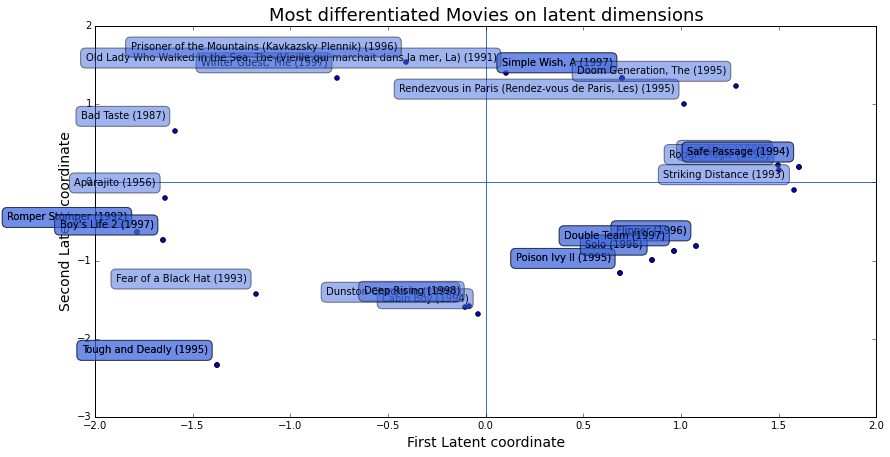

In [188]:
votes_by_movie = dict(ratings.groupby('item.id')['rating'].count())
itemsdf['votes_by_item'] = itemsdf['movie id '].apply(lambda x: votes_by_movie[x])

m_latent = q
max_votes_ix = itemsdf[itemsdf['votes_by_item'] > 215].index

set1 = np.argsort(m_latent[:,0])[0:4]
set2 = np.argsort(m_latent[:,0])[-4:]
set3 = np.argsort(m_latent[:,1])[0:4]
set4 = np.argsort(m_latent[:,1])[-4:]
set5 = np.argsort(m_latent[:,1] + m_latent[:,0])[0:4]
set6 = np.argsort(m_latent[:,1] + m_latent[:,0])[-4:]
set7 = np.argsort(m_latent[:,1] - m_latent[:,0])[0:4]
set8 = np.argsort(m_latent[:,1] - m_latent[:,0])[-4:]
set9 = np.argsort(abs(m_latent[:,1] + m_latent[:,0]))[0:4]
fullset = np.append(set1, [set2, set3, set4, set5, set6, set7, set7])

labels = itemsdf.ix[fullset, ' movie title ']
m_latent = m_latent[fullset,]

plt.scatter(x=m_latent[:,0], y=m_latent[:,1], marker='o')
for label, x, y in zip(labels, m_latent[:, 0], m_latent[:, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Most differentiated Movies on latent dimensions', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


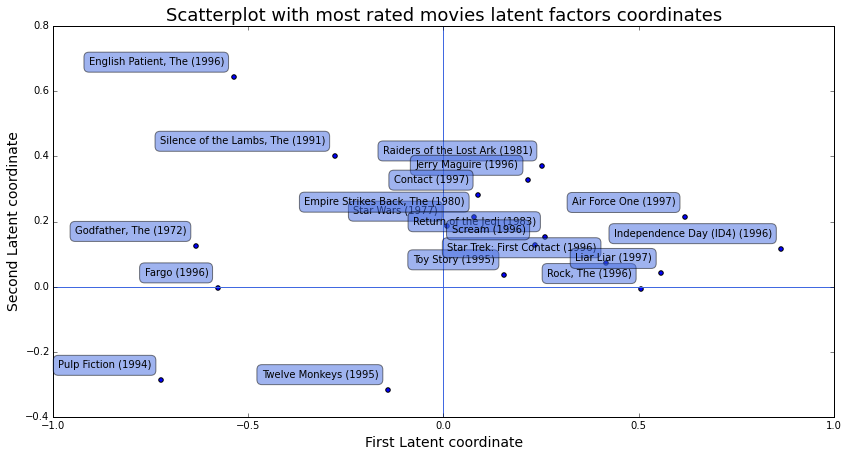

In [189]:
m_latent = q
max_votes_ix = itemsdf[itemsdf['votes_by_item'] > 360].index
labels = itemsdf.ix[itemsdf['votes_by_item'] > 360, ' movie title ']

plt.scatter(x=m_latent[max_votes_ix,0], y=m_latent[max_votes_ix,1], marker='o')
for label, x, y in zip(labels, m_latent[max_votes_ix, 0], m_latent[max_votes_ix, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Scatterplot with most rated movies latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

In [172]:
set1 = np.argsort(m_latent[:,0])[0:20]
print(itemsdf.ix[set1, 5:].mean())

set2 = np.argsort(m_latent[:,0])[-20:]
print(itemsdf.ix[set2, 5:].mean())

set3 = np.argsort(m_latent[:,1])[0:20]
print(itemsdf.ix[set3, 5:].mean())

set4 = np.argsort(m_latent[:,1])[-20:]
print(itemsdf.ix[set4, 5:].mean())

set5 = np.argsort(abs(m_latent[:,0] + m_latent[:,1]))[0:20]
print(itemsdf.ix[set5, 5:].mean())

 unknown         0.00
 Action          0.10
 Adventure       0.00
 Animation       0.00
 Children's      0.00
 Comedy          0.25
 Crime           0.00
 Documentary     0.00
 Drama           0.65
 Fantasy         0.00
 Film-Noir       0.00
 Horror          0.10
 Musical         0.00
 Mystery         0.00
 Romance         0.15
 Sci-Fi          0.00
 Thriller        0.05
 War             0.05
 Western         0.00
votes_by_item    7.90
dtype: float64
 unknown          0.00
 Action           0.15
 Adventure        0.10
 Animation        0.00
 Children's       0.20
 Comedy           0.35
 Crime            0.05
 Documentary      0.00
 Drama            0.30
 Fantasy          0.00
 Film-Noir        0.00
 Horror           0.10
 Musical          0.00
 Mystery          0.00
 Romance          0.15
 Sci-Fi           0.05
 Thriller         0.20
 War              0.00
 Western          0.00
votes_by_item    12.35
dtype: float64
 unknown          0.00
 Action           0.30
 Adventure        0.00
 

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


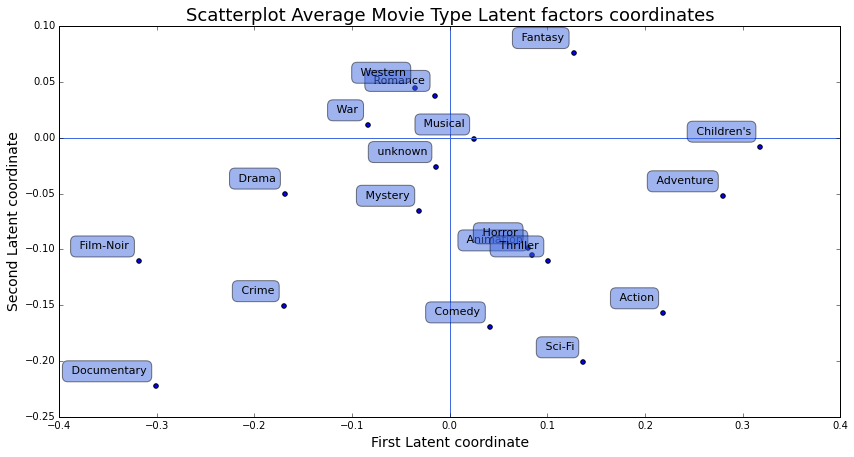

In [191]:
labels = itemsdf.columns[5:-2]
first = []
second = []

for column in itemsdf.columns[5:-2]:
    ix = itemsdf.ix[itemsdf[column] == 1,].index
    mean = np.mean(m_latent[ix,:], axis=0)
    first.append(mean[0])
    second.append(mean[1])
    
plt.scatter(x=first, y=second, marker='o')
for label, x, y in zip(labels, first, second):
    plt.annotate(
        label,
        fontsize=11,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')

plt.title('Scatterplot Average Movie Type Latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

### Model with 10 dimensions + dimensions with most variance

In [178]:
ndim = 10
batch_indexes = make_bins_i(len(obs_ui), 200)
p_init = np.random.rand(n_users, ndim) - 0.5
q_init = np.random.rand(n_items, ndim) - 0.5
bu_init = bu_init0
bi_init = bi_init0
mu_init = np.mean(obs_rates)

lrate = 0.1
reg = 0.1

(p10, q10, bu10, bi10, mu) = sgd_svdB(lrate, obs_ui, obs_rates, reg, batch_indexes,
                                q_init, p_init, bu_init, bi_init, mu_init)

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


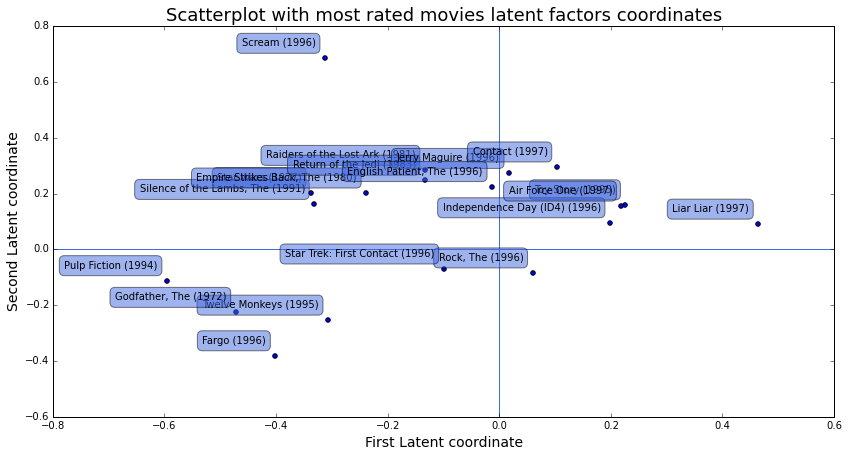

In [193]:
m_latent = q10
np.var(q10, axis=0)
m_latent = m_latent[:,[2,5]]

max_votes_ix = itemsdf[itemsdf['votes_by_item'] > 360].index
labels = itemsdf.ix[itemsdf['votes_by_item'] > 360, ' movie title ']

plt.scatter(x=m_latent[max_votes_ix,0], y=m_latent[max_votes_ix,1], marker='o')
for label, x, y in zip(labels, m_latent[max_votes_ix, 0], m_latent[max_votes_ix, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Scatterplot with most rated movies latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


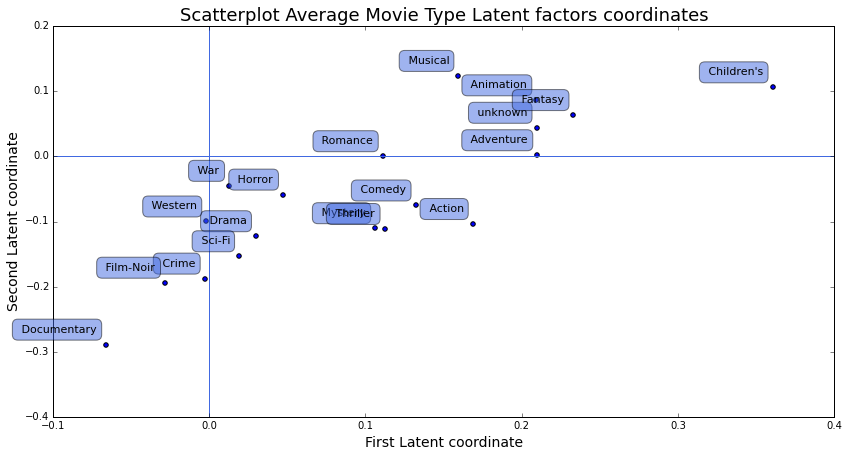

In [194]:
labels = itemsdf.columns[5:-2]
first = []
second = []

for column in itemsdf.columns[5:-2]:
    ix = itemsdf.ix[itemsdf[column] == 1,].index
    mean = np.mean(m_latent[ix,:], axis=0)
    first.append(mean[0])
    second.append(mean[1])
    
plt.scatter(x=first, y=second, marker='o')
for label, x, y in zip(labels, first, second):
    plt.annotate(
        label,
        fontsize=11,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')

plt.title('Scatterplot Average Movie Type Latent factors coordinates', fontsize=18)
plt.xlabel('First Latent coordinate', fontsize=14)
plt.ylabel('Second Latent coordinate', fontsize=14)

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


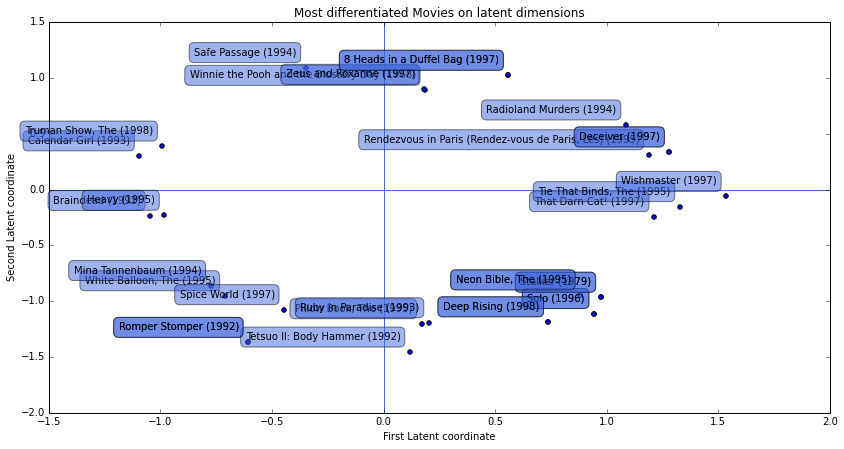

In [184]:
max_votes_ix = itemsdf[itemsdf['votes_by_item'] > 215].index

set1 = np.argsort(m_latent[:,0])[0:4]
set2 = np.argsort(m_latent[:,0])[-4:]
set3 = np.argsort(m_latent[:,1])[0:4]
set4 = np.argsort(m_latent[:,1])[-4:]
set5 = np.argsort(m_latent[:,1] + m_latent[:,0])[0:4]
set6 = np.argsort(m_latent[:,1] + m_latent[:,0])[-4:]
set7 = np.argsort(m_latent[:,1] - m_latent[:,0])[0:4]
set8 = np.argsort(m_latent[:,1] - m_latent[:,0])[-4:]
set9 = np.argsort(abs(m_latent[:,1] + m_latent[:,0]))[0:4]
fullset = np.append(set1, [set2, set3, set4, set5, set6, set7, set7])

labels = itemsdf.ix[fullset, ' movie title ']
m_latent = m_latent[fullset,]

plt.scatter(x=m_latent[:,0], y=m_latent[:,1], marker='o')
for label, x, y in zip(labels, m_latent[:, 0], m_latent[:, 1]):
    plt.annotate(
        label,
        fontsize=10,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'royalblue', alpha = 0.5))
plt.axhline(y=0.0, xmin=-0.5, xmax=2, linewidth=1, color = 'royalblue')
plt.axvline(x=0.0, ymin=-1, ymax=2, linewidth=1, color='royalblue')
plt.title('Most differentiated Movies on latent dimensions')
plt.xlabel('First Latent coordinate')
plt.ylabel('Second Latent coordinate')